# Data and Model Drift Detection for Tabular Data

This notebook provides sample code to detect drift in features or target labels over time. For instance, changes in the distribution of demographic variables like gender or age are observable in the training data. However, they might also impact model performance. Here, we are measuring the impact on model performance by comparing accuracy metrics based on the whole dataset with a window of recent data.  
The notebook was developed and tested using the ``Python 3.8-AzureML`` kernel on a Azure ML Compute Instance.

**In this notebook:**
- Retrieve sample datasets from CSV files and managed AML datasets
- Statistical tests and expressive visualizations to detect and analyze drift in features and model predictions
- Predictive approach to identify the impact of data and concept drift on the model
- Create automated pipelines to identify data drift regularly as part of an MLOps solution using Azure Machine Learning

# Setup

In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import pandas as pd
import numpy as np
import os
import json

from scipy.stats import ks_2samp, chisquare, chi2_contingency, gaussian_kde

from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMClassifier

from azureml.core import Workspace, Dataset

# Helper Functions

In [2]:
def distribution_intersection_area(A, B):
    """
    This function computes the intersection area between two kernel density estimates.

    inputs:
        A = numpy array of the reference distribution
        B = numpy array of the observed distribution
    
    output:
        area = intersection area in percent
        kde1_x = KDE values for A
        kde1_x = KDE values for B
        idx = intersection points of the two KDEs
        x = range of the distribution
    """

    kde1 = gaussian_kde(A, bw_method = "scott")
    kde2 = gaussian_kde(B, bw_method = "scott")

    xmin = min(A.min(), B.min())
    xmax = max(A.max(), B.max())
    dx = 0.2*(xmax - xmin)
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 1000)
    kde1_x = kde1(x)
    kde2_x = kde2(x)
    idx = np.argwhere(np.diff(np.sign(kde1_x - kde2_x))).flatten()

    area = np.trapz(np.minimum(kde1_x, kde2_x), x) # intersection area between of the kde curves, between the two intersection points
    return area, kde1_x, kde2_x, idx, x  

def plot_distribution_overlap(A, B, A_label='reference', B_label='current', ax=None):
    """
    This function computes the intersection area between two kernel density estimates.

    inputs:
        A = numpy array of the reference distribution
        B = numpy array of the observed distribution
        A_label = label you want to be displayed in the plot for series A
        B_label = label you want to be displayed in the plot for series B
    returns:
        matplotlib plot of intersection percentage of Gaussian KDE between A & B
    """
    if ax is None:
        ax = plt.gca()
    

    area, kde1_x, kde2_x, idx, x = distribution_intersection_area(A, B) # intersection area between of the kde curves, between the two intersection points

    ax.plot(x, kde1_x, color = 'dodgerblue', label = A_label, linewidth = 2)
    ax.plot(x, kde2_x, color = 'orangered', label = B_label, linewidth = 2)

    ax.fill_between(x, np.minimum(kde1_x, kde2_x), 0, color = 'lime', alpha = 0.3, label = 'intersection')

    ax.plot(x[idx], kde2_x[idx], 'ko')

    handles, labels = ax.get_legend_handles_labels()
    labels[2] += f': {area * 100:.1f}%'
    ax.legend(handles, labels)


def add_noise_last_index(array, max_value_reference_distribution,confidence_percentage):
    """
    This function re-populates a constant value according to the method described in add_noise_to_constant().

    inputs:
        array = constant value f(x) = k
        max_value_reference_distribution = max value from the distribution to be compared against (A or B)
        confidence_percentage = confidence interval that determines how many samples will be re-populated
    returns:
        array = recoded sample defined as:
            array interval = x ∈ {[k, max(A,B)]} with the probability defined as: 
            array probabilities: p((k, max(A,B)]), p(k) = constant
            array sample size:
                N (array) = n + n*(1-confidence_percentage) with:
                    n of x ∈ {(k, max(A,B)]} = n*(1-confidence_percentage) -> all values but k
                    n of x ∈ {k} = n -> includes k only

    """
    array = np.append(array, # N = original sample + new syntehtic values
                        np.linspace( # create a uniformly distributed sample
                            start=min(array), # start with the minimum value of the constant
                            stop=max_value_reference_distribution, # define the maximum range as max(A|B)
                            num=int((1-confidence_percentage)*len(array)))) #populate n of x ∈ {(k, max(A,B)]} according to confidence interval
    return array

def add_noise_to_constant(A, B):
    """
    This function is a helper function to compute the intersection area between two kernel density estimates.
    Because the derivative cannot be taken on constant values via numpy (singular matrix error), it is required
    to recode at least one value of a constant. This approach assumes a 95% CI (one tail), where non-constant values
    are populated uniformly between the max value of the reference distribution and the constant. All newly populated
    values contain the same probability but do not affect the distribution assuming a 95% CI. Using this logic, 
    we get plots that have similar KDE around the constant values and which align with the methods used in e.g. seaborn kde plots. 

    inputs:
        A = numpy array of the reference distribution
        B = numpy array of the observed distribution
        A_label = label you want to be displayed in the plot for series A
        B_label = label you want to be displayed in the plot for series B
    returns:
        matplotlib plot of intersection percentage of Gaussian KDE between A & B
    """
    if len(np.unique(np.array(B))) == 1:
        #print("Adding noise to constant value in current dataset")
        #A_freq = dict(zip(np.unique(A, return_counts=True)[0], np.unique(A, return_counts=True)[1]))
        confidence_percentage = 0.975 #this is based on a 95% CI with considering one tail only #max(A_freq.values()) / sum(A_freq.values())
        max_value_reference_distribution = max(A)
        B = add_noise_last_index(B, max_value_reference_distribution, confidence_percentage).astype("int")
    return B


def contingency_table(reference_col, current_col):
    index = list(set(reference_col.unique()) | set(current_col.unique()))

    value_counts_df = pd.DataFrame(reference_col.value_counts(), index=index)
    value_counts_df.columns = ['reference']
    value_counts_df['current'] = current_col.value_counts()
    value_counts_df.fillna(0, inplace=True)

    result = np.array([[value_counts_df['reference'].values], [value_counts_df['current'].values]])
    return result


def spilt_data(data, rct_split=(0.4, 0.4, 0.2), shuffle=False):
    if shuffle:
        data = data.sample(frac=1.0)

    rc_split_idx = round(rct_split[0] * data.shape[0])
    ct_split_idx = round((rct_split[0]+ (rct_split[1])) * data.shape[0])

    reference = data[:rc_split_idx]
    current = data[rc_split_idx:ct_split_idx]
    test = data[ct_split_idx:]

    return reference, current, test


# Read data

In [28]:
dataset = pd.read_csv("./data/predictive_maintanance.csv")
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

# TO BE DISCUSSED
# sort dataset chronologically and drop index. Suggestion: Apply to CSV
dataset = dataset.sort_values(by=['timestamp']).reset_index()

# Define timestamps for splitting
current_start = pd.to_datetime("01/06/2021")
test_start = pd.to_datetime("01/06/2022")

reference = dataset[dataset["timestamp"] <= current_start]
current = dataset[(dataset["timestamp"] >= current_start) & (dataset["timestamp"] < test_start)]
test = dataset[dataset["timestamp"] >= test_start]

# Sanity checking
print("reference min: ", reference["timestamp"].min(), " reference max: ", reference["timestamp"].max())
print("current min: ", current["timestamp"].min(), " current max: ", current["timestamp"].max())
print("test min: ", test["timestamp"].min(), " test max: ", test["timestamp"].max())

reference min:  2020-01-06 00:24:38  reference max:  2021-01-05 23:50:54
current min:  2021-01-06 00:16:07  current max:  2022-01-05 23:02:33
test min:  2022-01-06 00:00:10  test max:  2022-01-08 23:59:09


In [29]:
dataset

,index,heat_deviation,speed_deviation,assembly_line_num,days_since_last_service,sensor_back,sensor_front,operator,failure,timestamp
0,13060,-1.402682,4.241747,assembly_3,99,-3.405993,3.450679,operator4,0,2020-01-06 00:24:38
1,12429,-0.126422,1.930147,assembly_2,101,-3.413560,2.879816,operator3,0,2020-01-06 01:39:16
2,7690,0.102070,4.555567,assembly_1,100,-3.728655,0.073900,operator2,0,2020-01-06 01:49:17
3,17991,0.337126,0.903267,assembly_2,102,-3.562049,3.185188,operator2,0,2020-01-06 02:27:52
4,14060,-2.618703,-0.498052,assembly_1,100,2.491643,-2.057373,operator2,0,2020-01-06 02:28:29
...,...,...,...,...,...,...,...,...,...,...
44995,41153,0.592558,-0.735717,assembly_1,100,0.679219,0.747613,operator2,0,2022-01-08 23:56:27
44996,42127,-1.458949,-0.761666,assembly_3,100,1.850105,3.902713,operator2,0,2022-01-08 23:56:53
44997,44593,-0.838191,-2.909899,assembly_0,98,0.860230,0.894338,operator2,0,2022-01-08 23:57:56
44998,43917,-1.728545,2.942215,assembly_3,101,-0.425456,2.185823,operator3,0,2022-01-08 23:58:15


<span style='color:Red'> @Natasha: Can we do the following?  </span>

1. Sort dataset chronologically and apply to CSV (see my code in cell above)
2. Drop test Window for drift analysis for consistency with the doc and do the reference/current/test split in the predictive part further below

Since we assume that data drift impacted the dataset over time, we split the data into two consecutive windows, **reference** and **current**, using the ``split_data`` function: 

<img src="rc-drift.png" alt="Illustration of model drift detecion concepts" width="1200"/>

For real world drift detection, it is recommended to try different splits (sizes of the current window). Below, adjust the split to assess the drift impact on the model performance by comparing two classifieres, which are trained on two subsequent partitions and evaluated on the most recent test data.

# Data and Target Drift Analysis

## Specify Data Drift Analysis

In [4]:
# flag a variable as drifted if p-value is below the threshold
threshold = 0.01

# option to use shortlist of relevant columns
shortlist = ['heat_deviation', 'speed_deviation', 'days_since_last_service', 'sensor_back', 'sensor_front', 'assembly_line_num', 'operator',  'failure']

# shortlist = [] # if no shortlist present 

# use shortlist if exists, else all columns from reference
columns = reference.columns if shortlist == [] else shortlist

# identify numerical and categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(reference[columns])
categorical_columns = categorical_columns_selector(reference[columns])
   
# label encoding for plots of categorical columns
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

reference_le = categorical_transformer.fit_transform(reference[categorical_columns])
reference_le = pd.DataFrame(reference_le)
reference_le.columns = categorical_columns

current_le = categorical_transformer.transform(current[categorical_columns])
current_le = pd.DataFrame(current_le)
current_le.columns = categorical_columns

# impute missing values

if categorical_columns != []:

    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    current_le = imp_mode.fit_transform(current_le[categorical_columns])
    current_le = pd.DataFrame(current_le)
    current_le.columns = categorical_columns

    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    reference_le = imp_mode.fit_transform(reference_le[categorical_columns])
    reference_le = pd.DataFrame(reference_le)
    reference_le.columns = categorical_columns

In [5]:
print(f'numerical columns: {numerical_columns}')
print(f'categorical columns: {categorical_columns}')

numerical columns: ['heat_deviation', 'speed_deviation', 'days_since_last_service', 'sensor_back', 'sensor_front', 'failure']
categorical columns: ['assembly_line_num', 'operator']


## Viualize Results
- **KS Test** for continuous data: What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?
- **Chi Square Test** for categorical data: Pearson's chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table

Columns type not recognized


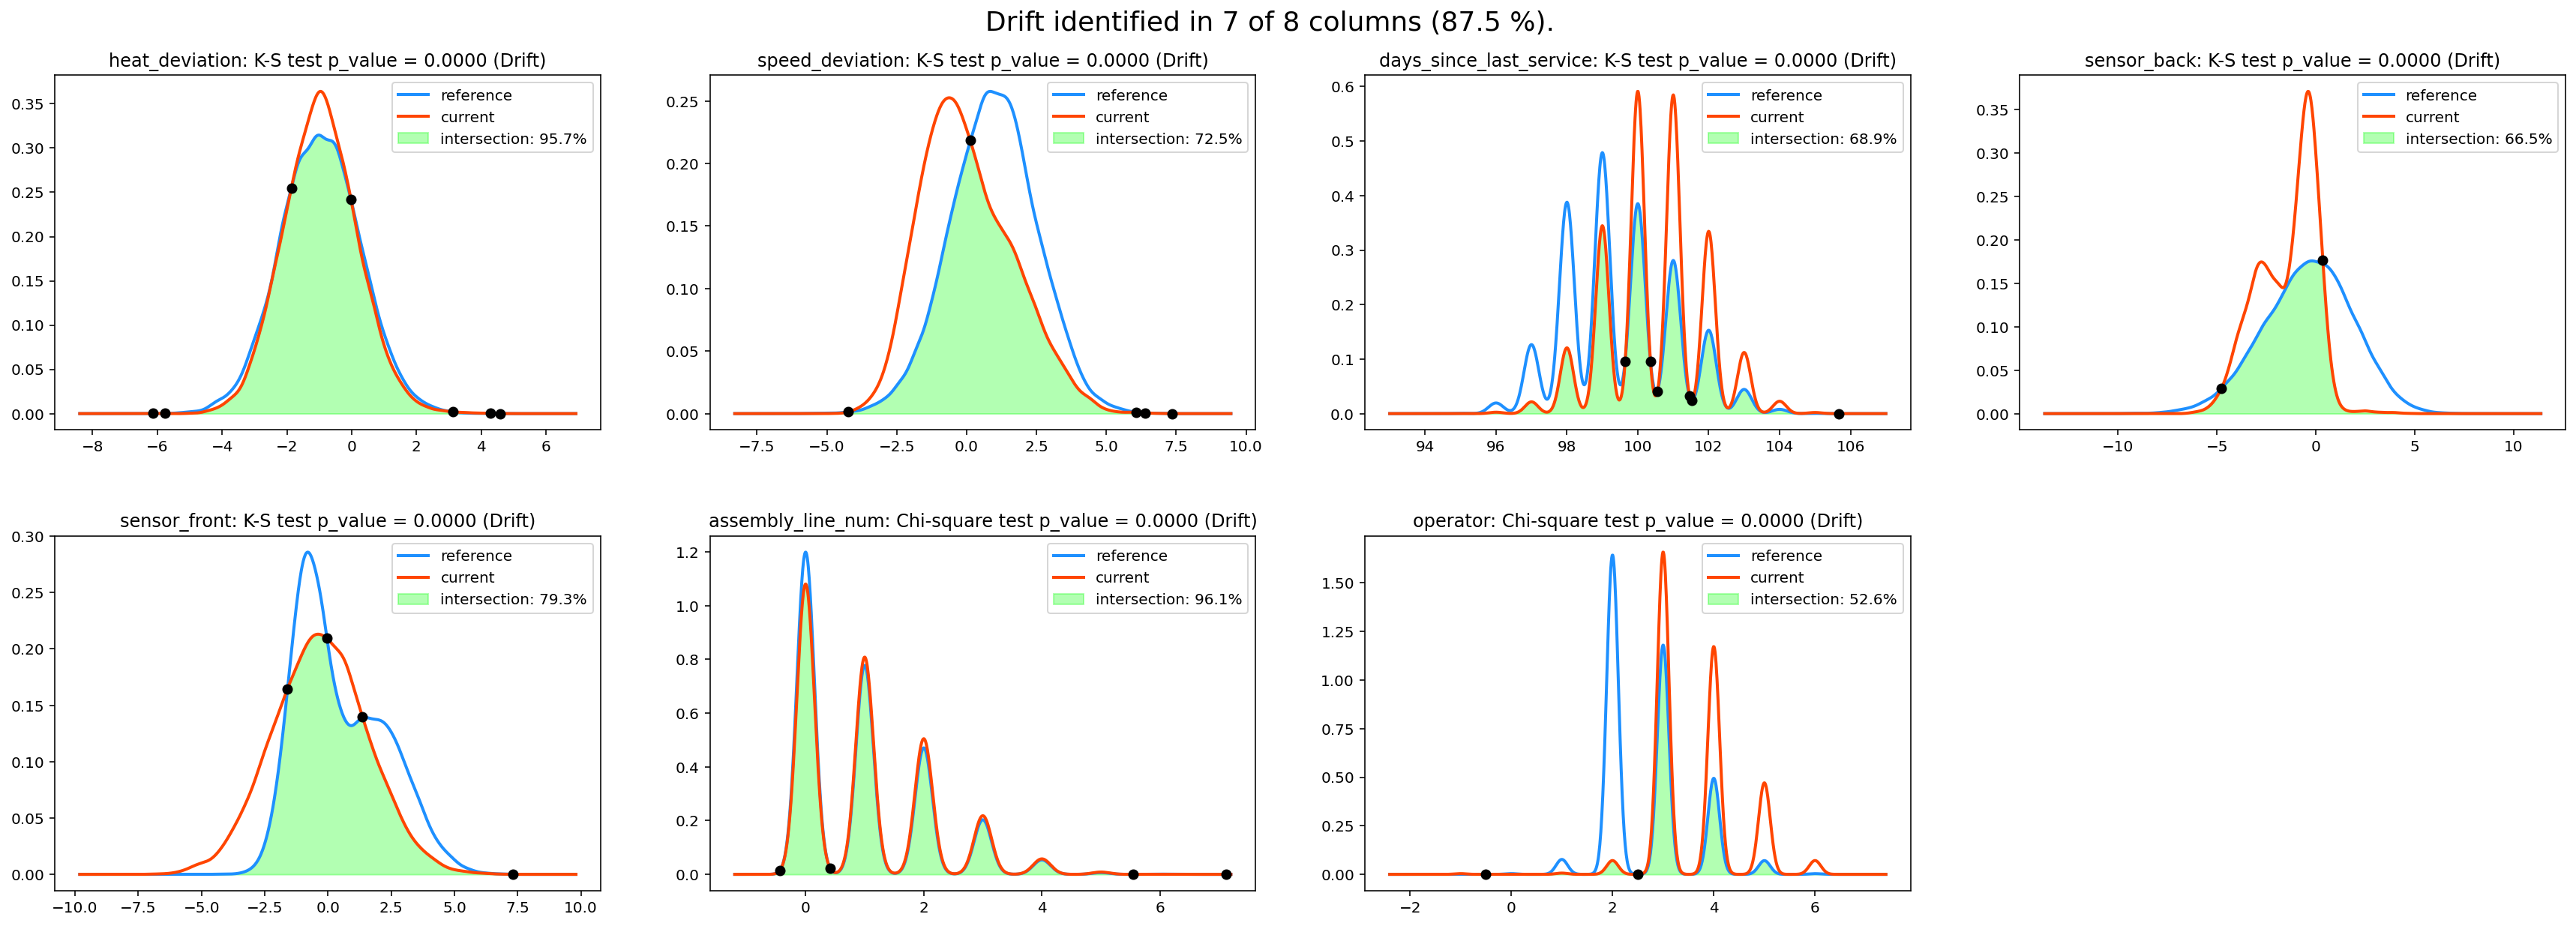

In [20]:
# prepare plot
total = len(columns)
display_cols = 4

rows = total // display_cols
rows += total % display_cols
position = range(1, total + 1)

fig = plt.figure(figsize=(30, 5 * rows))
fig.subplots_adjust(hspace= 0.3, wspace=0.2)

drift_cols = 0
for k, col in enumerate(columns):
    
    if col in numerical_columns:
        
        # statistical test:
        statistic, p_value = ks_2samp(reference[col].values, current[col].values)
        if p_value < threshold:
            drift_indication = 'Drift'
            drift_cols += 1
        else:
            drift_indication = 'No drift'
        annot = f'{col}: K-S test p_value = {p_value:.4f} ({drift_indication})'
        
        # plot:
        ref_arr = np.sort(reference[col])
        curr_arr = np.sort(current[col])

        # add noise to enable plotting when constant values present
        ref_arr = add_noise_to_constant(A=curr_arr, B=ref_arr) #this assumes the reference distribution is a constant
        curr_arr = add_noise_to_constant(A=ref_arr, B=curr_arr) #this assumes the current distribution is a constant

        ax = fig.add_subplot(rows, display_cols, position[k])
        try: 
            plot_distribution_overlap(A = ref_arr, B = curr_arr, A_label = 'reference', B_label ='current', ax=ax)
        except Exception as e:
            annot = f'{col} - {e}'
            print(annot)

        ax.set_title(annot)
       
    elif col in categorical_columns:
        
        # statistical test:
        observations = contingency_table(reference_le[col], current_le[col])
        statstic, p_value, dof, _ = chi2_contingency(observations)
        if p_value < threshold:
            drift_indication = 'Drift'
            drift_cols += 1
        else:
            drift_indication = 'No drift'
        annot = f'{col}: Chi-square test p_value = {p_value:.4f} ({drift_indication})'

        # plot:
        ref_arr = np.sort(reference_le[col])
        curr_arr = np.sort(current_le[col])

        # add noise to enable plotting when constant values present
        ref_arr = add_noise_to_constant(A=curr_arr, B=ref_arr) #this assumes the reference distribution is a constant
        curr_arr = add_noise_to_constant(A=ref_arr, B=curr_arr) #this assumes the current distribution is a constant

        ax = fig.add_subplot(rows, display_cols, position[k])
        
        try:
            plot_distribution_overlap(A = ref_arr, B = curr_arr, A_label = 'reference', B_label ='current', ax=ax)
        except Exception as e:
            annot = f'{col} - {e}'
            print(annot)
        
        ax.set_title(annot)
        
    else:
        print('Columns type not recognized')

drift_stat = f'Drift identified in {drift_cols} of {len(columns)} columns ({drift_cols/len(columns) * 100:.1f} %).'
plt.suptitle(drift_stat, y=0.94, fontsize = 18)

plt.show()

# Predictive approach to identify the impact of data or concept drift on the model

Now we are assessing dataset drift impact on model performance by training and comparing two classifiers that will be trained  on the **reference** and **current** datasets. Both classifiers are evaluated on the same test set that represents the latest observations:

<img src="model-drift.png" alt="Illustration of model drift detecion concepts" width="1200"/>

Unlike the statistical tests above, all features of the dataset are used for training (no shortlist).

In [10]:
# creating refereence and current windows plus test set

X_reference, y_reference = reference.drop(['failure', 'timestamp'], axis=1), reference['failure']
X_current, y_current = current.drop(['failure', 'timestamp'], axis=1), current['failure']
X_test, y_test = test.drop(['failure', 'timestamp'], axis=1), test['failure']

## Create training pipeline

In [11]:
[df.shape for df in [X_reference, X_current, X_test]]

[(20000, 7), (20000, 7), (5000, 7)]

In [12]:
X_current

,heat_deviation,speed_deviation,assembly_line_num,days_since_last_service,sensor_back,sensor_front,operator
20000,2.415185,-0.253158,assembly_0,97,4.091698,0.328613,operator4
20001,-0.272735,2.757563,assembly_3,101,-3.756265,0.018368,operator3
20002,-0.935005,2.518478,assembly_1,101,-3.127137,0.709984,operator3
20003,1.259547,0.108375,assembly_0,103,-0.513584,-4.058916,operator3
20004,-1.173875,0.349985,assembly_0,100,-0.166306,0.738933,operator3
...,...,...,...,...,...,...,...
39995,-0.762447,0.111941,assembly_0,100,-0.323626,0.020987,operator4
39996,-0.101068,0.000526,assembly_2,101,-1.869904,-1.387872,operator3
39997,-1.693015,-1.093818,assembly_1,101,-1.822164,-0.540260,operator4
39998,-1.424897,-0.200315,assembly_1,99,0.207296,0.920234,operator3


In [13]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_reference)
categorical_columns = categorical_columns_selector(X_reference)

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('standard_scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

## Fit on reference window 

In [15]:
from sklearn.metrics import roc_auc_score
 
reference_clf = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', LGBMClassifier())])

reference_clf.fit(X_reference, y_reference)
reference_pred = reference_clf.predict(X_test)
reference_probas = reference_clf.predict_proba(X_test)

print('Reference set classification report:')
print(classification_report(y_test, reference_pred, digits=4))
print("ROC AUC",round(roc_auc_score(y_test, reference_probas[:,1]), 3))

Reference set classification report:
              precision    recall  f1-score   support

           0     0.9739    0.9032    0.9372      4875
           1     0.0146    0.0560    0.0232       125

    accuracy                         0.8820      5000
   macro avg     0.4943    0.4796    0.4802      5000
weighted avg     0.9499    0.8820    0.9144      5000

ROC AUC 0.58


## Fit on current window

In [16]:
current_clf = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', LGBMClassifier())])

current_clf.fit(X_current, y_current)
current_pred = current_clf.predict(X_test)
current_probas = current_clf.predict_proba(X_test)

print('\nCurrent set classification report:')
print(classification_report(y_test, current_pred, digits=4))
print("ROC AUC", round(roc_auc_score(y_test, current_probas[:,1]), 3))


Current set classification report:
              precision    recall  f1-score   support

           0     0.9863    0.9327    0.9588      4875
           1     0.1590    0.4960    0.2408       125

    accuracy                         0.9218      5000
   macro avg     0.5727    0.7144    0.5998      5000
weighted avg     0.9657    0.9218    0.9408      5000

ROC AUC 0.775


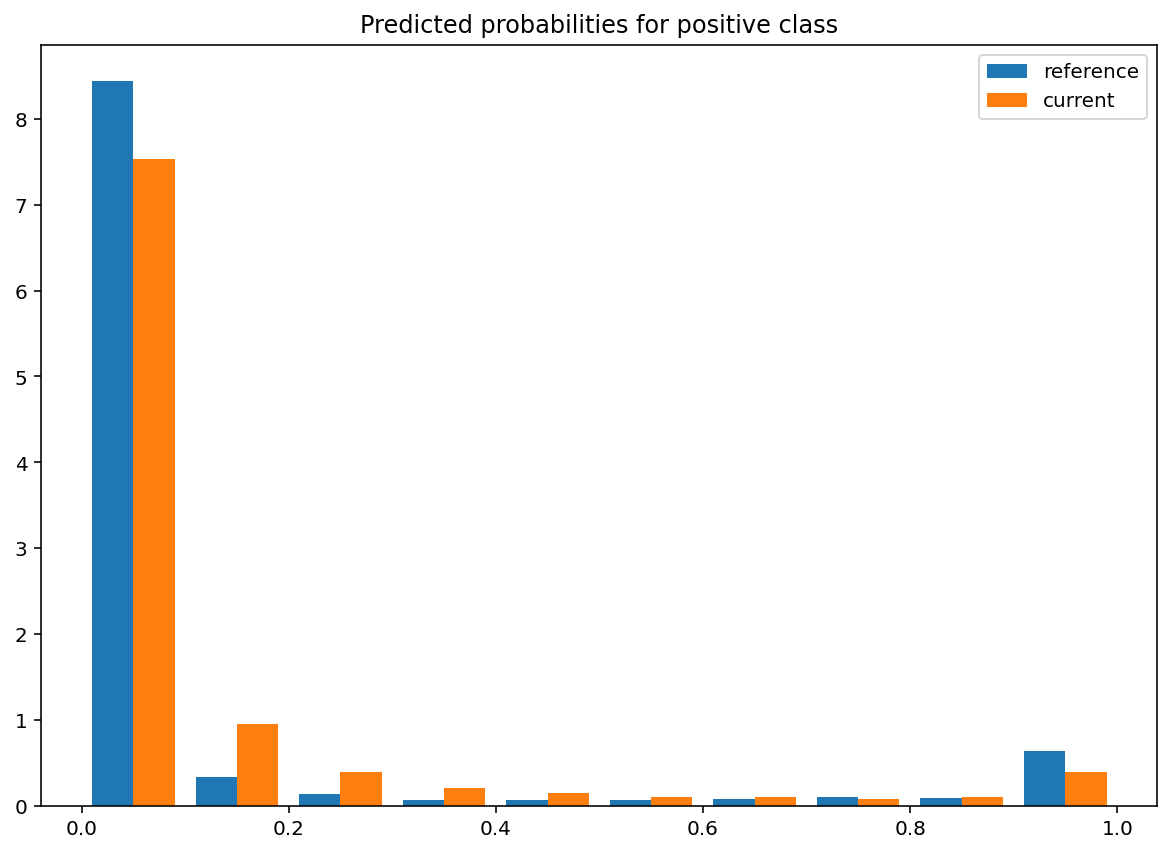

In [17]:
ref_arr = np.sort(reference_probas[:,1])
curr_arr = np.sort(current_probas[:,1])


fig, ax = plt.subplots(figsize=(10,7))
plt.hist([ref_arr, curr_arr], label=['reference', 'current'], density=True)
plt.legend(loc='upper right')
plt.title('Predicted probabilities for positive class')
plt.show()

In [18]:
statistic, p_value = ks_2samp(reference_probas[:,1], current_probas[:,1])
if p_value < threshold:
    drift_indication = 'Drift'
else:
    drift_indication = 'No drift'
annot = f'Probability distribution of positive class: K-S test p_value = {p_value:.4f} ({drift_indication})'
print(annot)

Probability distribution of positive class: K-S test p_value = 0.0000 (Drift)


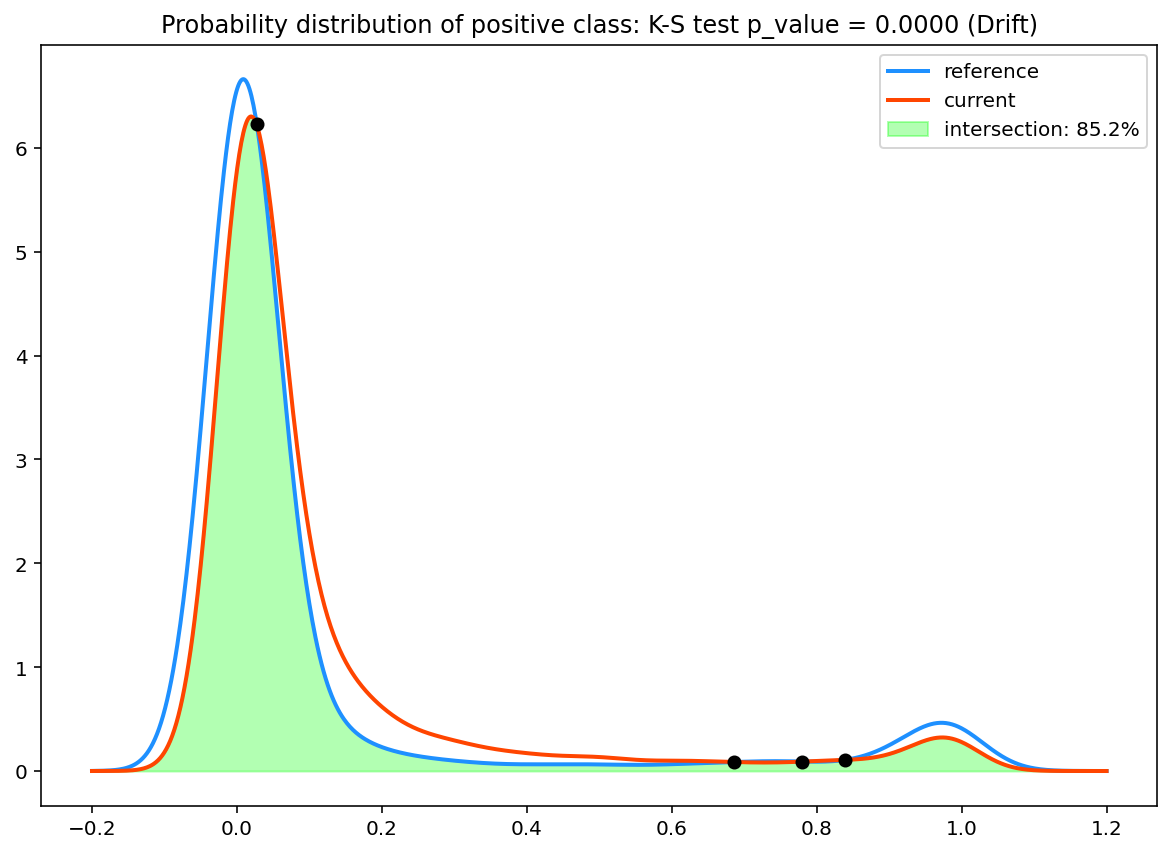

In [19]:
fig, ax = plt.subplots(figsize=(10,7))

plot_distribution_overlap(A = ref_arr, B = curr_arr, A_label = 'reference', B_label ='current', ax=ax)
ax.set_title(annot)

plt.show()

In [ ]:
stop here

# Data drift identification as part of an AzureML MLOps Pipeline

Use the following code to upload an existing csv to an AML Datastore and register as a managed dataset. This can later be used as input for the data drift detection pipeline. 

```python
# local data to be uploaded to the datastore
data_folder = './data/'
filename_A = 'reference_adult.csv'
filename_B = 'current_adult.csv'

# target in datastore
datastore_path = 'amldatasets/adult/current/'

# dataset infos
name_A = 'reference_adult_data'
name_B = 'current_adult_data'

description = 'Data drift testing dataset'
tags = {'Project' : 'adult-census',
        'Format' : 'CSV'}

reference.to_csv(f"{data_folder}{filename_A}", index=False)
current.to_csv(f"{data_folder}{filename_B}", index=False)


ws = Workspace.from_config()

# get default datastore
datastore = ws.get_default_datastore()

files = [os.path.join(data_folder, filename_A), os.path.join(data_folder, filename_B)]

# upload data file to AML datastore:
datastore.upload_files(files = files, 
                       target_path = datastore_path,
                       overwrite = True,
                       show_progress = True)


# register as AML dataset
dataset_A = Dataset.Tabular.from_delimited_files(path = (datastore, datastore_path + filename_A))

dataset_A.register(ws, 
                 name=name_A, 
                 description=description,
                 tags = tags,
                 create_new_version = True)


# register as AML dataset
dataset_B = Dataset.Tabular.from_delimited_files(path = (datastore, datastore_path + filename_B))

dataset_B.register(ws, 
                 name=name_B, 
                 description=description,
                 tags = tags,
                 create_new_version = True)

```

## Run an AML Experiment to test code on a remote compute instance

In [ ]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import RunConfiguration
from azureml.pipeline.core import Pipeline, PipelineParameter, PublishedPipeline, Schedule, ScheduleRecurrence
from azureml.pipeline.steps import PythonScriptStep
from azureml.widgets import RunDetails
from azureml.core.runconfig import RunConfiguration


#SET UP THE EXPERIMENT
exp_folder = './experiment'
compute_name = 'cpu-cluster'

workspace = Workspace.from_config()   

# Create a Python environment for the experiment (from a .yml file)
env = Environment.from_conda_specification("experiment_env", f"{exp_folder}/environment_pipeline.yml")

script_params = [
    '--reference_dataset', "reference_adult_data",
     '--current_dataset', "current_adult_data",
     '--threshold', 0.01,
     '--shortlist', "None"]

# Create a script config
script_config = ScriptRunConfig(source_directory=exp_folder,
                                script='data_drift_pipeline.py',
                                environment=env,
                                compute_target = compute_name, 
                                arguments = script_params)

# submit the experiment
experiment = Experiment(workspace, name = 'Data_Drift_Experiment')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion(show_output=False)

## Define an AML Pipeline

In [ ]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import RunConfiguration
from azureml.pipeline.core import Pipeline, PipelineParameter, PublishedPipeline, Schedule, ScheduleRecurrence
from azureml.pipeline.steps import PythonScriptStep
from azureml.widgets import RunDetails
from azureml.core.runconfig import RunConfiguration

#SET UP THE EXPERIMENT
exp_folder = './experiment'
compute_name = 'cpu-cluster'

workspace = Workspace.from_config()   

# Create a Python environment for the experiment (from a .yml file)
env = Environment.from_conda_specification("experiment_env", f"{exp_folder}/environment_pipeline.yml")

aml_run_config = RunConfiguration()
aml_run_config.environment = env

pipeline_parameters = {
     'reference_dataset': "reference_adult_data",
     'current_dataset': "current_adult_data",
     'threshold': 0.01,
     'shortlist': "None"}


# Step to run a Python script
step1 = PythonScriptStep(name = 'detect_data_drift',
                         source_directory = exp_folder,
                         script_name = 'data_drift_pipeline.py',
                        arguments=[
                            "--reference_dataset", PipelineParameter(name="reference_dataset", default_value=pipeline_parameters["reference_dataset"]),
                            "--current_dataset", PipelineParameter(name="current_dataset", default_value=pipeline_parameters["current_dataset"]),
                            "--threshold", PipelineParameter(name="threshold", default_value=pipeline_parameters["threshold"]),
                            "--shortlist", PipelineParameter(name="shortlist", default_value=pipeline_parameters["shortlist"]),
                                                     ],
                         runconfig = aml_run_config,
                         compute_target = 'cpu-cluster',
                         allow_reuse=False)

# Construct the pipeline
deploy_pipeline = Pipeline(workspace = workspace, steps = [step1])

# Create an experiment and run the pipeline
experiment = Experiment(workspace = workspace, name = 'deployment-pipeline')


pipeline_run = experiment.submit(deploy_pipeline, pipeline_parameters=pipeline_parameters)

## Publish an AML Pipeline

In [ ]:
# Publish the pipeline
published_pipeline = deploy_pipeline.publish(name='detect_data_drift_pipeline',
                                                  description='Generic data drift pipeline',
                                                  version='1.0')

rest_endpoint = published_pipeline.endpoint
print(rest_endpoint)

##  Add pipeline to a schedule

In [ ]:
# Schedule pipeline for periodic intervals

daily = ScheduleRecurrence(frequency='Month', interval=1)
pipeline_schedule = Schedule.create(workspace, name='Monthly retraining',
                                        description='Monthly data drift detection',
                                        pipeline_id=published_pipeline.id,
                                        experiment_name='detect_data_drift',
                                        recurrence=daily)

In [ ]:
# list schedules
schedule = Schedule.list(workspace) 
print(schedule)